# Perfil de usuário (log)

Neste Notebook, procura-se possíveis grupos de perfil de usuários baseados features extraídos do arquivo anonimized_logs.csv.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [38]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [8]:
logData = pd.read_csv("/content/drive/My Drive/Disciplinas/Lab avancado de ciencias de dados/new_data/anonimized_logs.csv") 
logData.head()

,user_uuid,moment,kind,iterable_uuid
0,57928,2016-09-12,EXERCISE_ANSWERED,2918d775-73e8-4c33-a3b7-5f0726bbe3ca
1,73719,2016-09-12,EXERCISE_ANSWERED,1315cdde-14e1-412d-bc3b-5da04b7aa44a
2,38957,2016-09-12,EXERCISE_ANSWERED,2ec53649-0eae-4114-b21f-ad72d448180b
3,59788,2016-09-12,EXERCISE_ANSWERED,ad5ae7b6-918f-4dfe-8680-db2928fe732c
4,73719,2016-09-12,EXERCISE_ANSWERED,7e08ee37-3eb6-4412-a6dd-d01f5619d2a2


In [9]:
print(logData.info())
print(f'Há nesse conjunto {len(logData.index)} registros de log')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18533471 entries, 0 to 18533470
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_uuid      int64 
 1   moment         object
 2   kind           object
 3   iterable_uuid  object
dtypes: int64(1), object(3)
memory usage: 565.6+ MB
None
Há nesse conjunto 18533471 registros de log


In [10]:
logData.kind.value_counts()

EXERCISE_ANSWERED      18000612
COURSE_FINISHED          426290
FORUM_POSTED              67213
FORUM_SOLVED              13963
CAREER_FINISHED           12514
DEGREE_FINISHED            9247
SUGGESTION_APPROVED        3558
PROJECT_APPROVED             74
Name: kind, dtype: int64

Há log de 73601 usuários distintos


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


entre 1 a 10 logs           8317
entre 11 a 100 logs        25599
entre 101 a 1000 logs      36690
entre 1001 a 13753 logs     2995
dtype: int64


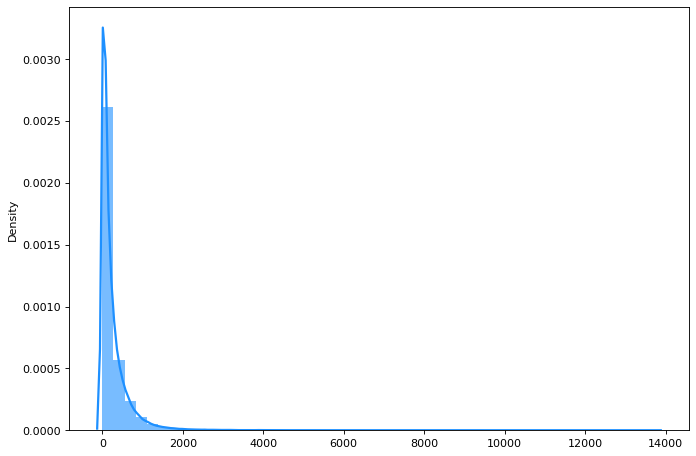

In [17]:
uniqueUserLogCount = logData.user_uuid.value_counts()
print(f'Há log de {uniqueUserLogCount.shape[0]} usuários distintos')


plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(uniqueUserLogCount.values, color="dodgerblue", label="Compact", **kwargs)

temp_count=np.array([uniqueUserActivityCount.values[uniqueUserActivityCount.values<=10].shape[0],
                     uniqueUserActivityCount.values[uniqueUserActivityCount.values<=100].shape[0],
                     uniqueUserActivityCount.values[uniqueUserActivityCount.values<=1000].shape[0],
                     uniqueUserActivityCount.values[uniqueUserActivityCount.values<=13753].shape[0],
                     ])

log_distribution=np.array(
    [temp_count[0],
     temp_count[1]-temp_count[0],
     temp_count[2]-temp_count[1],
     temp_count[3]-temp_count[2],
    ]
)
print(pd.Series(log_distribution, index =["entre 1 a 10 logs","entre 11 a 100 logs","entre 101 a 1000 logs","entre 1001 a 13753 logs"])) 

In [18]:
def getDateDiff(date1, date2):
  date1_parsed = date1.split('-')
  date2_parsed = date2.split('-')
  date1_obj = datetime.datetime(int(date1_parsed[0]), int(date1_parsed[1]),int(date1_parsed[2]))
  date2_obj = datetime.datetime(int(date2_parsed[0]), int(date2_parsed[1]), int(date2_parsed[2]))
  return((date2_obj-date1_obj).days)

In [43]:
def basicStatistic(data):
  st = np.array([data.max(), data.min(), data.mean(), np.median(data), np.std(data)])
  sr = pd.Series(st, index =["max","min","média","mediano","des. pad."])
  print(sr) 

In [53]:
size = uniqueUserActivityCount.values[uniqueUserActivityCount.values>500].shape[0]

users =  uniqueUserActivityCount.index[:size]

log_density = np.zeros((size))
daily_log_density = np.zeros((size))
interval = np.zeros((size))
log_counts = uniqueUserActivityCount.values[:size]

for i in range (size):
  is_user =  logData['user_uuid']==users[i]
  logData_user = logData[is_user]
  sorted_logData_user = logData_user.sort_values(by = 'moment')
  dates = sorted_logData_user['moment'].values

  interval[i]=(getDateDiff(dates[0],dates[dates.shape[0]-1])+1)
  log_density[i]=sorted_logData_user.moment.value_counts().index.shape[0] / interval[i]
  daily_log_density[i] = sorted_logData_user.moment.value_counts().mean()

max          1446.000000
min             3.000000
média         677.054282
mediano       635.000000
des. pad.     400.153416
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


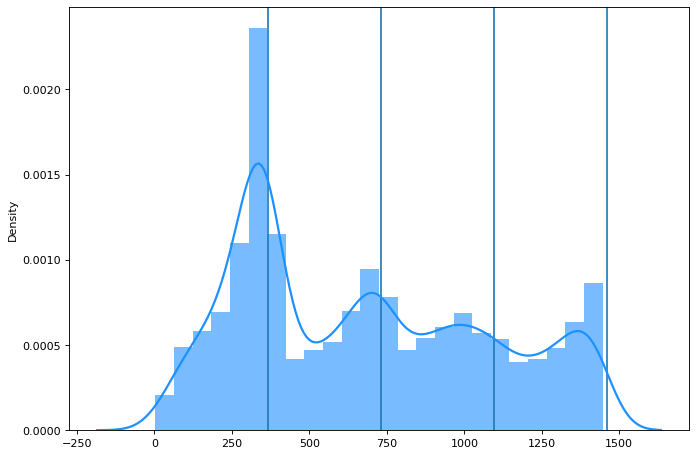

In [54]:
# analisando os intervalos
basicStatistic(interval)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.axvline(365)
plt.axvline(730)
plt.axvline(1095)
plt.axvline(1460)
sns.distplot(interval, color="dodgerblue", label="Compact", **kwargs)

max          1.000000
min          0.014433
média        0.193062
mediano      0.156863
des. pad.    0.134985
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


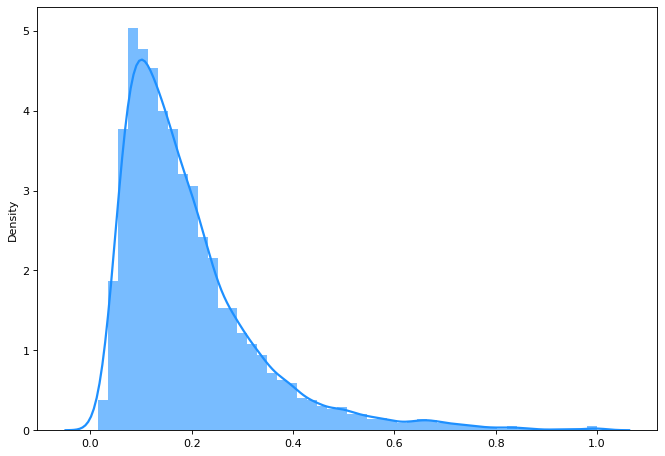

In [55]:
# analisando os quantidade dias de atividade por intervalo total
basicStatistic(log_density)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(log_density, color="dodgerblue", label="Compact", **kwargs)

max          567.000000
min            2.108434
média         11.854938
mediano        9.221111
des. pad.     12.505269
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


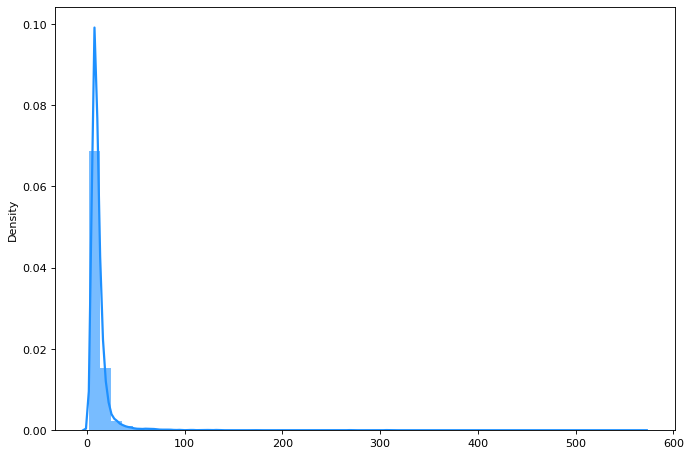

In [57]:
# analisando os quantidade log por dias de atividade
basicStatistic(daily_log_density)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(daily_log_density, color="dodgerblue", label="Compact", **kwargs)

max          13753.000000
min            501.000000
média          956.935763
mediano        760.000000
des. pad.      683.293167
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


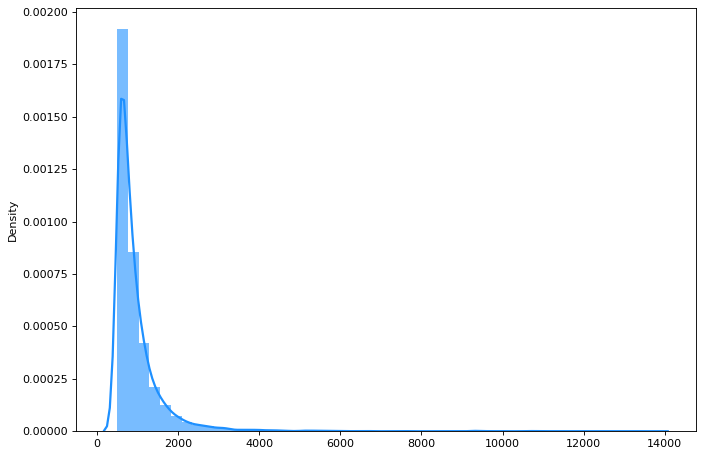

In [58]:
# analisando os quantidade de logs por usuários
basicStatistic(log_counts)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(log_counts, color="dodgerblue", label="Compact", **kwargs)

In [64]:
df = pd.DataFrame({'interval': interval})
df['log_density'] = log_density
df['daily_log_density'] = daily_log_density
df['log_counts'] = log_counts

df.corr()

,interval,log_density,daily_log_density,log_counts
interval,1.000000,-0.569503,-0.231092,0.181723
log_density,-0.569503,1.000000,0.079322,0.159798
daily_log_density,-0.231092,0.079322,1.000000,0.301005
log_counts,0.181723,0.159798,0.301005,1.000000


In [60]:
colors=np.log(log_counts)
area = np.pi*10
cmap = sns.cubehelix_palette(dark=0, light=0.7,as_cmap=True)

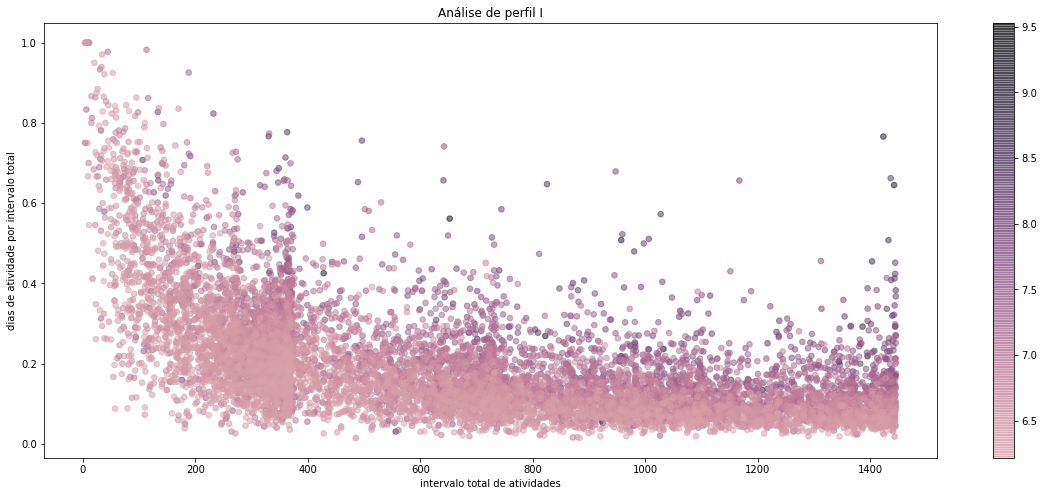

In [62]:
#maior correlação
plt.figure(figsize=(20,8))
sc =plt.scatter(interval, log_density, s=area, c=colors, alpha=0.5,cmap=cmap)


plt.title('Análise de perfil I')
plt.xlabel('intervalo total de atividades')
plt.ylabel('dias de atividade por intervalo total')
plt.colorbar(sc)
plt.show()

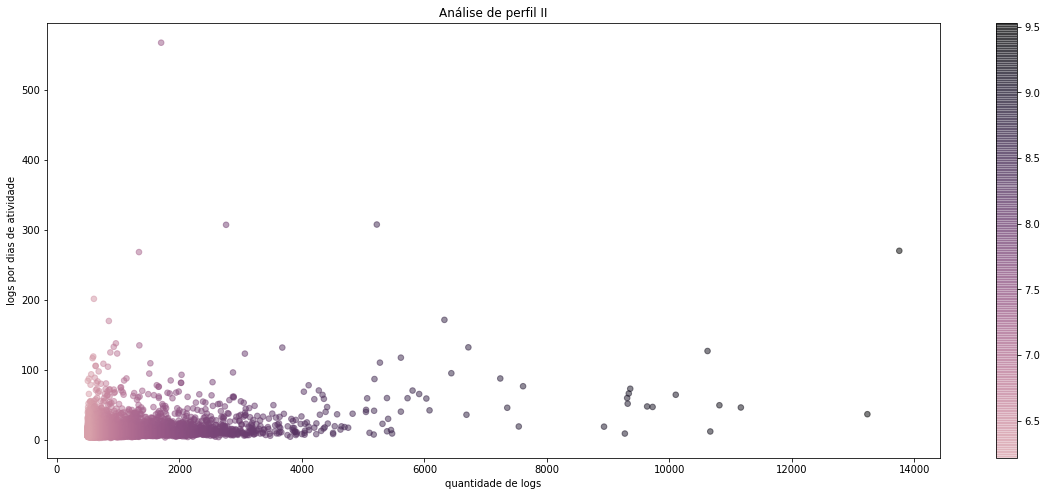

In [72]:
#2a maior correlação
plt.figure(figsize=(20,8))
sc =plt.scatter(log_counts,daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)


plt.title('Análise de perfil II')
plt.xlabel('quantidade de logs')
plt.ylabel('logs por dias de atividade')
plt.colorbar(sc)
plt.show()

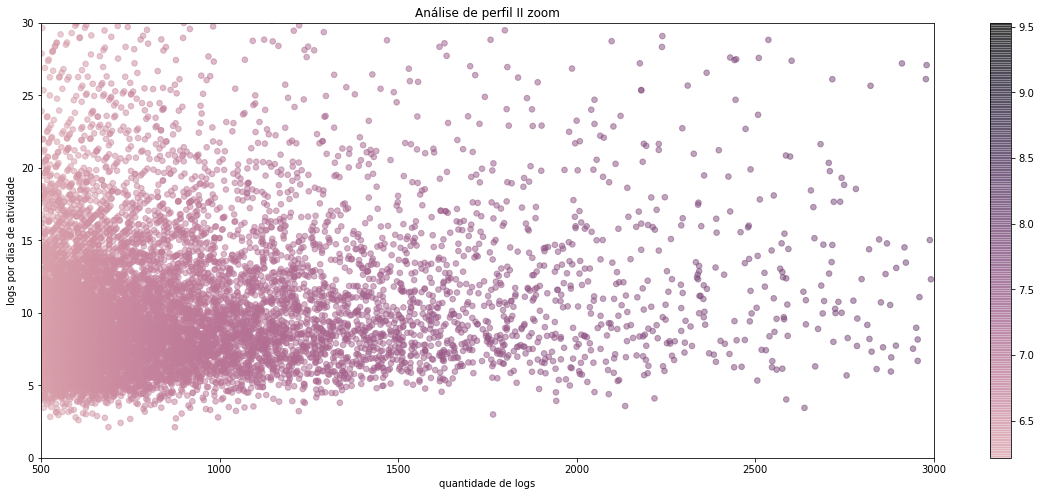

In [75]:
#2a maior correlação
plt.figure(figsize=(20,8))
sc =plt.scatter(log_counts,daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)

plt.xlim(500, 3000)
plt.ylim(0, 30)
plt.title('Análise de perfil II zoom')
plt.xlabel('quantidade de logs')
plt.ylabel('logs por dias de atividade')
plt.colorbar(sc)
plt.show()

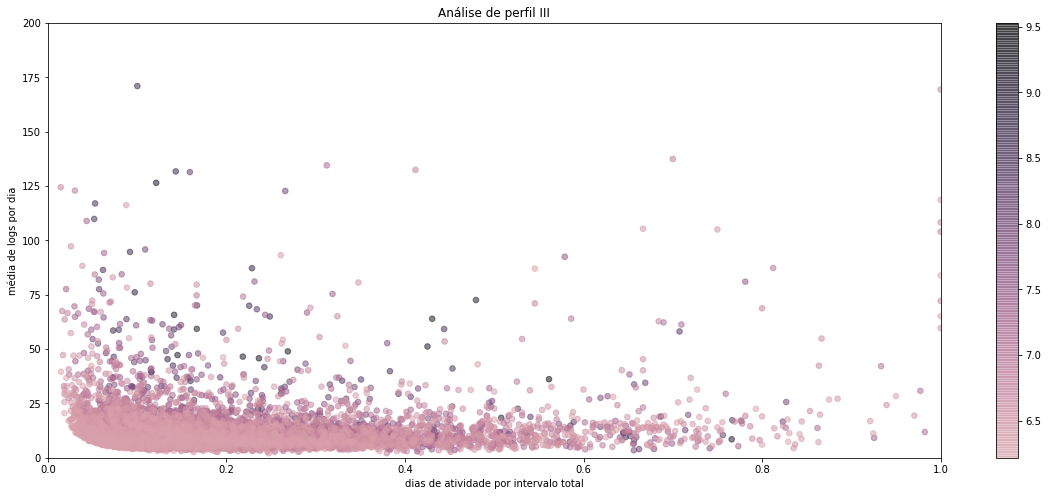

In [76]:
plt.figure(figsize=(20,8))
sc =plt.scatter(log_density, daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)

plt.xlim(0, 1)
plt.ylim(0, 200)
plt.title('Análise de perfil III')
plt.xlabel('dias de atividade por intervalo total')
plt.ylabel('média de logs por dia')
plt.colorbar(sc)
plt.show()

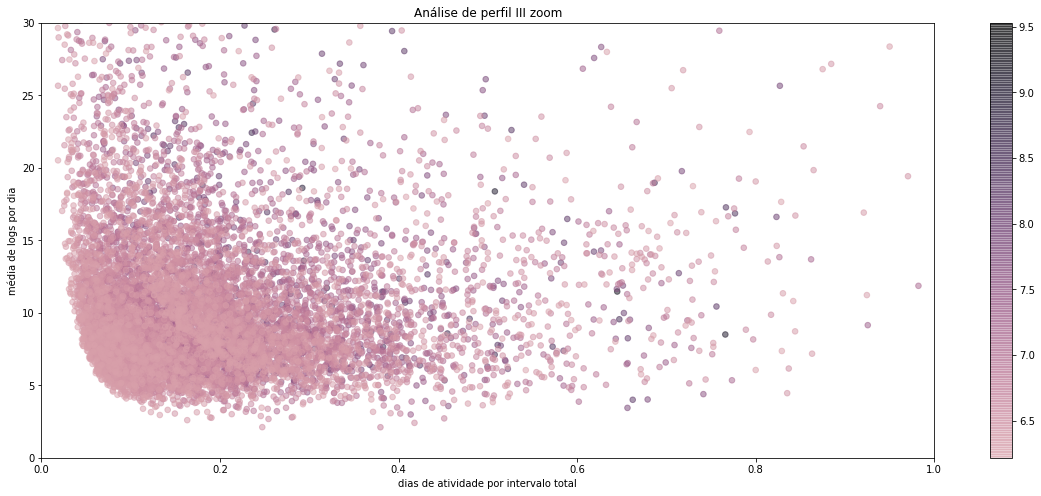

In [78]:
plt.figure(figsize=(20,8))
sc =plt.scatter(log_density, daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)

plt.xlim(0, 1)
plt.ylim(0, 30)
plt.title('Análise de perfil III zoom')
plt.xlabel('dias de atividade por intervalo total')
plt.ylabel('média de logs por dia')
plt.colorbar(sc)
plt.show()